In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
humidity_temp_df = pd.read_csv("/content/Report_Table & diagram.csv")
power_df = pd.read_csv("/content/KW 8331_105632NAH 1319_Recording_NITSOL3.csv")
humidity_temp_df.dropna(inplace=True)
power_df.dropna(inplace=True)

In [ ]:
# Convert timestamps
humidity_temp_df['Date/time'] = pd.to_datetime(humidity_temp_df['Date/time'], dayfirst=True)
power_df['Datetime'] = pd.to_datetime(power_df['Date of Measurement'] + ' ' + power_df['Time of Measurement'], dayfirst=True)
power_df.drop(columns=['Date of Measurement', 'Time of Measurement', 'Measurement Units'], inplace=True)

In [ ]:
# Merge
merged_df = pd.merge_asof(humidity_temp_df.sort_values('Date/time'),
                          power_df.sort_values('Datetime'),
                          left_on='Date/time',
                          right_on='Datetime',
                          direction='nearest')

In [ ]:
# Rename for clarity
merged_df.rename(columns={'Dry Bulb [°C]': 'Temperature',
                          'Relative Humidi [%rH]': 'Humidity',
                          'Measurement Value': 'Power',
                          'Date/time': 'Timestamp'}, inplace=True)

In [ ]:
# Time series power data
ts_power = merged_df[['Timestamp', 'Power']].dropna()
ts_power = ts_power.set_index('Timestamp').resample('H').mean().interpolate()

<ipython-input-11-d4edd5c27196>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_power = ts_power.set_index('Timestamp').resample('H').mean().interpolate()


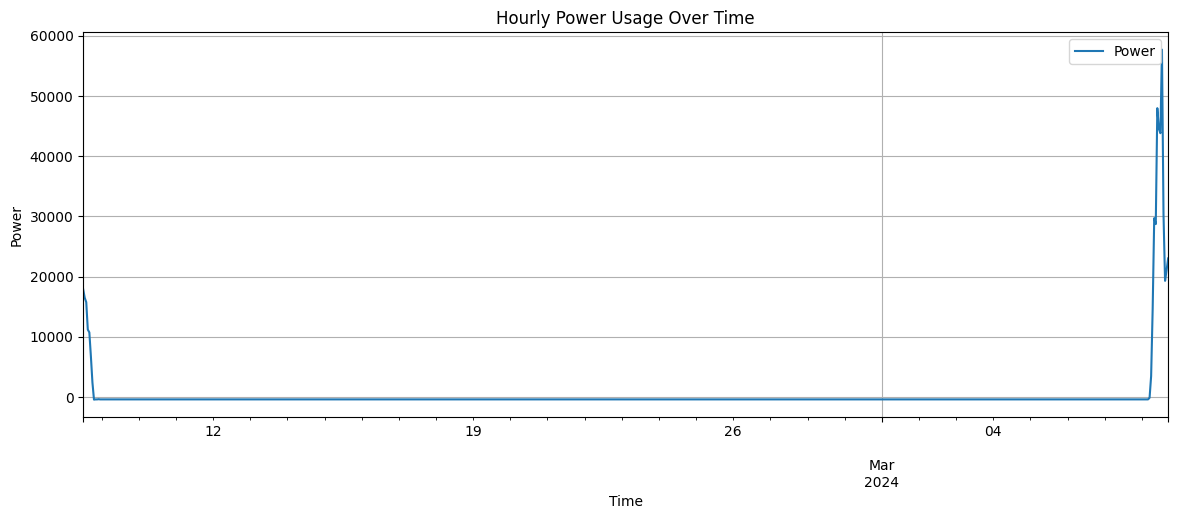

In [ ]:
# Plot
ts_power.plot(figsize=(14,5), title="Hourly Power Usage Over Time")
plt.ylabel("Power")
plt.xlabel("Time")
plt.grid(True)
plt.show()

In [ ]:
!pip install numpy==1.26.4 pandas==2.2.2 scipy==1.13.0 statsmodels==0.14.1 pmdarima==2.0.4 --quiet

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# Reload datasets
df_power = pd.read_csv("/content/KW 8331_105632NAH 1319_Recording_NITSOL3.csv")
df_env = pd.read_csv("/content/Report_Table & diagram.csv")

# Step 1: Combine date and time into a single datetime column
df_power["Datetime"] = pd.to_datetime(df_power["Date of Measurement"] + " " + df_power["Time of Measurement"])
df_power = df_power[["Datetime", "Measurement Value"]]

# Convert environment datetime column
df_env["Datetime"] = pd.to_datetime(df_env["Date/time"], format="%d-%m-%Y %H:%M")

# Step 2: Merge both datasets on nearest datetime
df_combined = pd.merge_asof(
    df_power.sort_values("Datetime"),
    df_env.sort_values("Datetime")[["Datetime", "Dry Bulb [°C]", "Relative Humidi [%rH]"]],
    on="Datetime",
    direction="nearest"
)

# Step 3: Drop rows with any missing values
df_combined.dropna(inplace=True)

# Step 4: Normalize features for LSTM
from sklearn.preprocessing import MinMaxScaler

feature_cols = ["Measurement Value", "Dry Bulb [°C]", "Relative Humidi [%rH]"]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_combined[feature_cols])
scaled_df = pd.DataFrame(scaled_data, columns=feature_cols)

# Step 5: Create sequences for LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predict 'Measurement Value'
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(scaled_data, sequence_length)

# Step 6: Split into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X.shape, y.shape, X_train.shape, X_test.shape


((874, 10, 3), (874,), (699, 10, 3), (175, 10, 3))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0448 - mae: 0.1598 


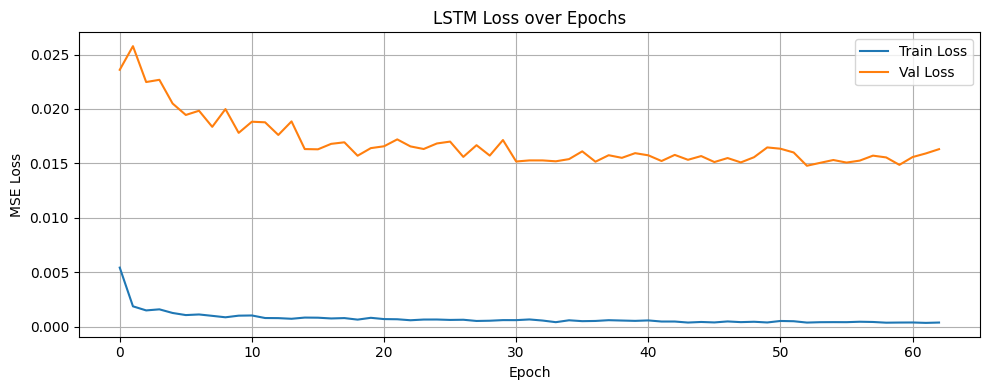

(0.03098181076347828, 0.12513211369514465)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Step 7: Define LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 8: Train model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0  # Set to 1 to view training logs
)

# Step 9: Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test)

# Step 10: Plot loss curves
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

test_loss, test_mae


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0131 - mae: 0.0715 - val_loss: 0.0413 - val_mae: 0.1498
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0020 - mae: 0.0273 - val_loss: 0.0177 - val_mae: 0.0881
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0018 - mae: 0.0236 - val_loss: 0.0180 - val_mae: 0.0900
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 9.3976e-04 - mae: 0.0153 - val_loss: 0.0173 - val_mae: 0.0879
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0010 - mae: 0.0150 - val_loss: 0.0168 - val_mae: 0.0863
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 8.1678e-04 - mae: 0.0143 - val_loss: 0.0169 - val_mae: 0.0882
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 7.7648e-04 - mae: 0.0155 - val_loss: 0.0163 - val_mae: 0.0845
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 9.1331e-04 - mae: 0.0152 - val_loss: 0.0160 - val_mae: 0.0834
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step 

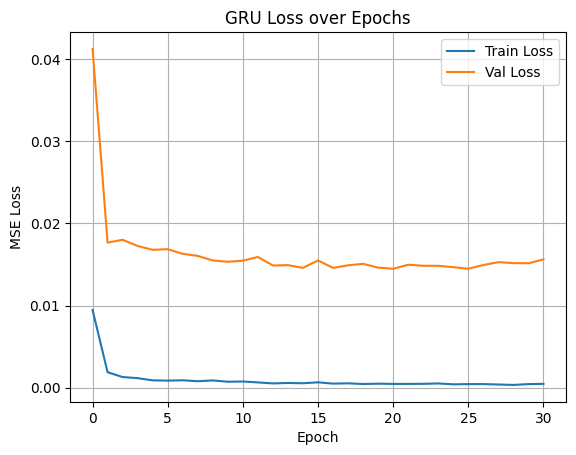

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Assuming df_combined is already created and contains the following columns:
# 'Measurement Value', 'Dry Bulb [°C]', 'Relative Humidi [%rH]'

# Normalize features
feature_cols = ["Measurement Value", "Dry Bulb [°C]", "Relative Humidi [%rH]"]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_combined[feature_cols])

# Create sequences
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # predict 'Measurement Value'
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(scaled_data, sequence_length)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# GRU model
model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test Loss (MSE):", test_loss)
print("Test MAE:", test_mae)

# Plot loss curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('GRU Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()
